In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
from scipy.optimize import curve_fit

In [0]:
url = 'https://raw.githubusercontent.com/Andrea-Perin/EX_STAT_MECH/master/bci05.csv'
df = pd.read_csv(url, sep=",") #dataframe

data = df[df['status']=='A']
data = data[['sp','gx','gy']]

arr = data.values #array

# TASK 1

In [0]:
#dividing the plot in N subplots

plot_length = 1000 #metres
plot_height = 500  #metres
N = 800 #number of subplots
Sub_area = plot_length*plot_height/N #area of each subplot in square meters

#assuming square subplots of side l
l = np.sqrt(Sub_area)
mod_len = int(plot_length//l) #number of subplots that can be fit in the length
mod_hei = int(plot_height//l) #number of subplots that can be fit in the height

#creating a grid of subplots: each subplot is represented by its lower left edge
subplots = np.array([np.array([i*l,j*l]) for i in range(mod_len) for j in range(mod_hei)])

#utility series that holds all species with count 0
specs = data['sp'].unique() #all the different species
completion = pd.Series(np.zeros(len(specs), dtype=int),specs)

#utility function; checks if x is in the interval [y, y+l). Used to group the trees in their respective subplot.
@jit(nopython=True)
def between(x,y,l):
    return np.logical_and(np.less(x,y+l),np.greater_equal(x,y))

#for each lower left vertex (which denotes a subplot) the different numbers of each species are collected
abundancies = np.array([
    
    data[np.logical_and(between(data['gx'].values,subplots[i,0],l), between(data['gy'].values,subplots[i,1],l))]['sp'].value_counts().sort_index()
    
                for i in range(N)])

    
#the following contains ALL species, even the ones not appearing in the subplot
ab2 = [pd.concat([i,completion])[~pd.concat([i,completion]).index.duplicated(keep='first')].sort_index()
                for i in abundancies]




big_matrix = np.array(ab2) # a matrix of shape N*S
index = ab2[0].index.to_numpy() # the array containing the names of the species

X = big_matrix.flatten() 
X = X[np.nonzero(X)] # the vector containing only the present species

# TASK 2

P(1) = 1.0


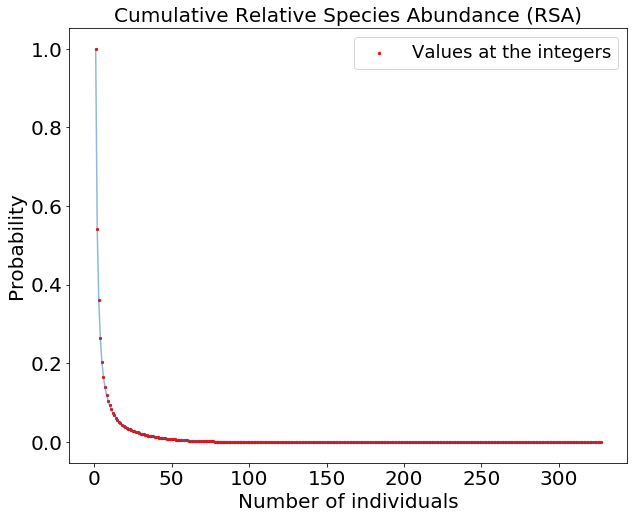

In [22]:
def emp_cum_dist(x, vector=X):
    return np.count_nonzero(vector>=x)/(vector.shape[0])


xs = np.arange(1, max(X), 1)
ys = np.array([emp_cum_dist(x) for x in xs])

plt.figure(figsize=(10,8))
plt.title("Cumulative Relative Species Abundance (RSA)", fontsize=20)
plt.xlabel("Number of individuals", fontsize=20)
plt.ylabel("Probability", fontsize=20)
plt.plot(xs, ys, alpha=0.5)
plt.tick_params(axis='both', labelsize=20)
plt.scatter(xs, ys, c='r', s=5, label="Values at the integers")
plt.legend(fontsize=18)

print("P(1) =", emp_cum_dist(1))

# TASK 3

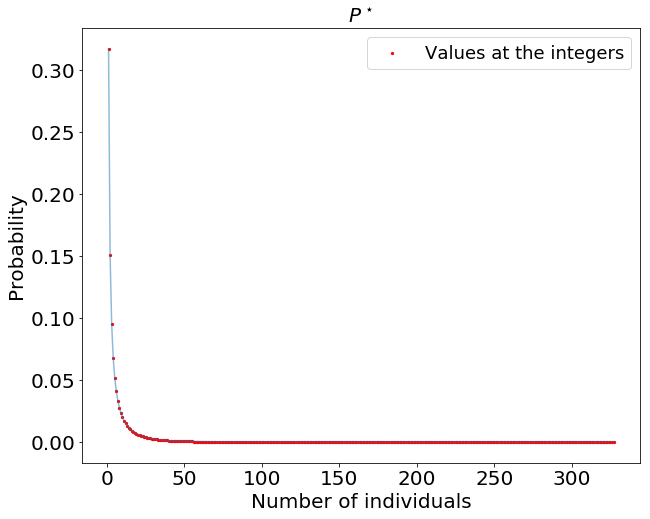

In [23]:
n = 1
ν = 0.05

def p_star(n, ν=ν):
    return ((ν*(1-ν)**n)/(np.log(ν)))*(1/n)

xs = np.arange(1, max(X), 1)
ys2 = np.array([p_star(x) for x in xs])
norm = np.sum(ys2)

ys2 = ys2/norm

plt.figure(figsize=(10,8))
plt.title(r"$P^\star$", fontsize=20)
plt.xlabel("Number of individuals", fontsize=20)
plt.ylabel("Probability", fontsize=20)
plt.plot(xs, ys2, alpha=0.5)
plt.tick_params(axis='both', labelsize=20)
plt.scatter(xs, ys2, c='r', s=5, label="Values at the integers")
plt.legend(fontsize=18)
plt.show()

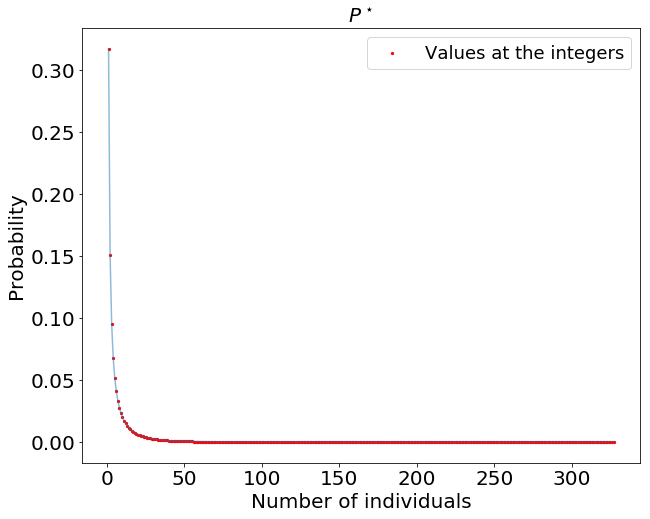

In [24]:
n = 1
ν = 0.05

def p_star_th(n, ν=ν):
    return -(((1-ν)**n)/(np.log(ν)))*(1/n)

xs = np.arange(1, max(X), 1)
ys2t = np.array([p_star_th(x) for x in xs])


plt.figure(figsize=(10,8))
plt.title(r"$P^\star$", fontsize=20)
plt.xlabel("Number of individuals", fontsize=20)
plt.ylabel("Probability", fontsize=20)
plt.plot(xs, ys2t, alpha=0.5)
plt.tick_params(axis='both', labelsize=20)
plt.scatter(xs, ys2t, c='r', s=5, label="Values at the integers")
plt.legend(fontsize=18)
plt.show()

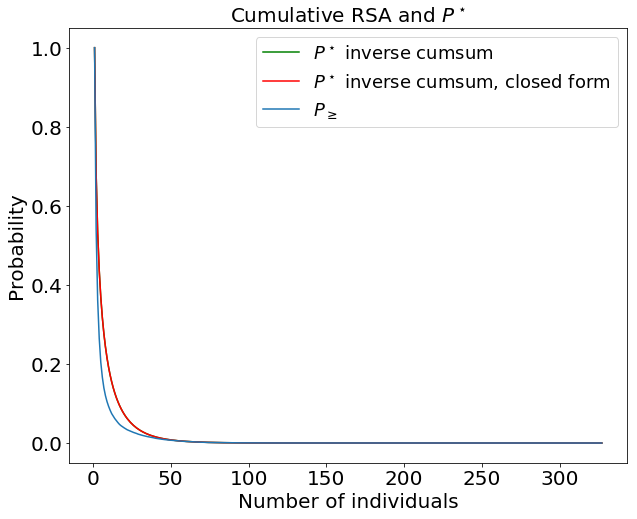

In [25]:
plt.figure(figsize=(10,8))
plt.title(r"Cumulative RSA and $P^\star$", fontsize=20)
plt.xlabel("Number of individuals", fontsize=20)
plt.ylabel("Probability", fontsize=20)


plt.plot(xs, np.cumsum(ys2[::-1])[::-1] , alpha=1, label=r"$P^\star$ inverse cumsum", c='g') 
plt.plot(xs, np.cumsum(ys2t[::-1])[::-1] , alpha=1, label=r"$P^\star$ inverse cumsum, closed form", c='r') 


#plt.plot(xs, ys2 , alpha=1, label=r"$P^\star$")
plt.plot(xs, ys, alpha=1, label=r"$P_\geq$")
plt.tick_params(axis='both', labelsize=20)
plt.legend(fontsize=18)
plt.show()

# TASK 4

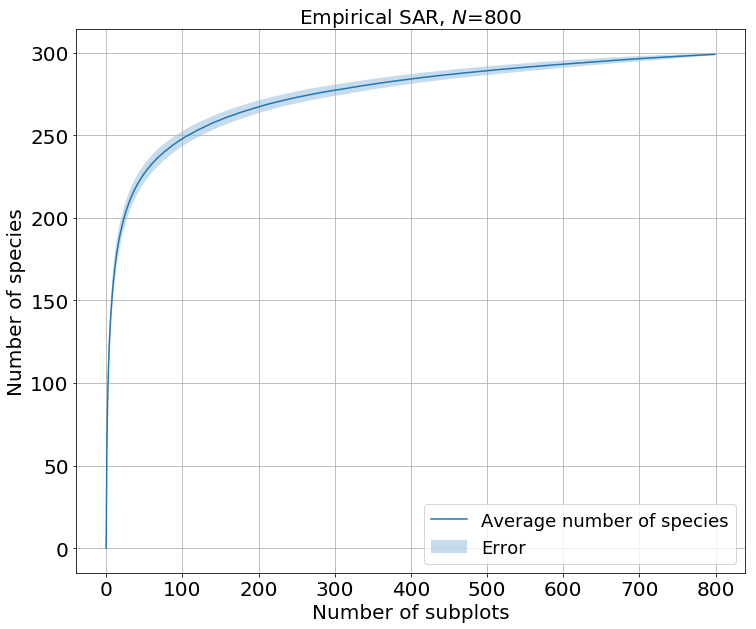

In [26]:
#empirical SAR

def build_traj(Num_slots=N, plot=big_matrix):
    
    # this function calculates the number of species as a function of the number of analyzed subplots
    # the ordering of such subplots is random; it will then be averaged

    on_off = plot.astype(bool)
    index = np.random.permutation(np.arange(Num_slots)) #creates a random ordering for the plots
    
    num_of_species = np.array([np.count_nonzero(np.bitwise_or.reduce(on_off[index[:n]])) for n in range(Num_slots)])
    
    return num_of_species

Num_trials = 1000 #number of trajectories over which to average
emp = []
for i in range(Num_trials):
    emp.append(build_traj())
    
mean = np.mean(emp, axis=0)
std = np.std(emp, axis=0)



#building the empirical plot

plt.figure(figsize=(12,10))
plt.title(r"Empirical SAR, $N$=800", fontsize=20)
plt.xlabel("Number of subplots", fontsize=20)
plt.ylabel("Number of species", fontsize=20)
plt.grid()

#for val in emp:
#    plt.plot(val, alpha=0.1, color='k')
#  
#plt.plot(emp[0], alpha=0, label='Single realizations')

plt.plot(mean, label="Average number of species")
plt.fill_between(np.arange(N), mean-std, mean+std, alpha=0.25, label="Error")

# building the predicted function from neutral theory


plt.tick_params(axis='both', labelsize=20)
plt.legend(fontsize=18)
plt.show()

Fitting function:
$$
\langle S(ja) \rangle = S\left(1-\frac{\log \left( j\frac{a}{A} (1-\nu) + \nu \right)}{\log \nu} \right)
$$

where $j$ is the number of subplots used, $a$ is the size of a single subplot, $A$ is the total area of the whole plot. $\nu$ is the immigration rate.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


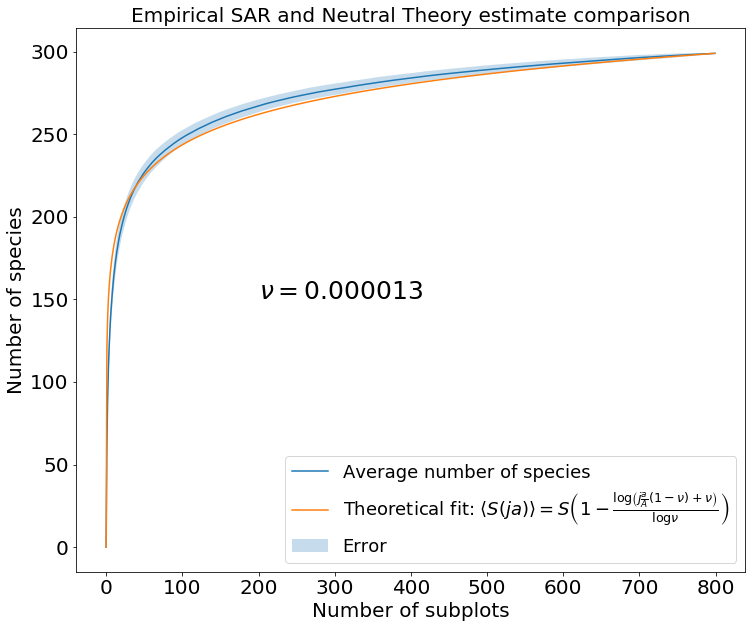

In [27]:
xs = np.linspace(0,N,N)

def func(x, v):
    S=299
    a=1/800
    return S*(1-(np.log(x*a*(1-v)+v))/(np.log(v)))



plt.figure(figsize=(12,10))
plt.title("Empirical SAR and Neutral Theory estimate comparison", fontsize=20)
plt.xlabel("Number of subplots", fontsize=20)
plt.ylabel("Number of species", fontsize=20)
plt.plot(mean, label="Average number of species")
plt.fill_between(np.arange(N), mean-std, mean+std, alpha=0.25, label="Error")
plt.tick_params(axis='both', labelsize=20)


# fitting the function
params, pcov = curve_fit(func, xs, mean, p0=0.0001)
plt.plot(func(xs, *params), 
         label=r"Theoretical fit: $\langle S(ja) \rangle = S\left(1-\frac{\log \left( j\frac{a}{A} (1-\nu) + \nu \right)}{\log \nu} \right)$")
plt.text(200, 150, r"$\nu =%.6f$" % params, fontsize=25)
plt.legend(fontsize=18)

# TASK  5

In [0]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy import integrate
from numba import jit

In [0]:
@jit
def log_growth(b,K,m,nIters,nSamples):
  A = np.zeros((nSamples,nIters))
  ts = np.zeros((nSamples, nIters))
  #A[:,0] = np.random.choice(2*K, size=nSamples, replace=True)
  A[:,0]=0
  for n in range(nSamples):
    for t in range(nIters-1):
      At = A[n,t]
      wp = b*At+m
      wm = b*At*At/K
      w = wp + wm
      ts[n,t+1] = ts[n,t]+ np.random.exponential(1/w)
      if(np.random.rand()<wp/w):
        A[n,t+1]=At+1
      else:
        A[n,t+1]=At-1
  return ts, A

In [0]:
def log_growth_pdf(A, b=1, K=10, m=0.1):
  r=m/b
  lnP_A = A*np.log(K)-np.log(sc.special.factorial(A))
  for k in np.arange(len(A)):
    lnP_A[k] = lnP_A[k] + np.sum(np.log(1+(r-1)/np.arange(1,A[k]+1)))
  P_A = np.exp(lnP_A)
  return P_A/sum(P_A)

In [0]:
K=10
ts, A = log_growth(1, K, 0.1, 1000, 1000)

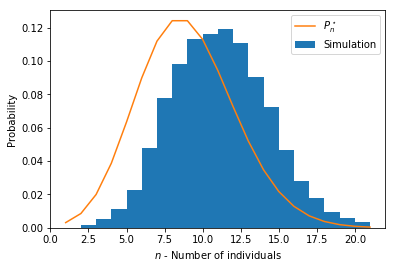

In [32]:
subA = np.ravel(A[:,-5:-1] )
temp = np.arange(1,np.max(subA)+1)
counts, _, _ = plt.hist(subA, density=True, bins=temp, label='Simulation')
lgpdf = log_growth_pdf(temp, b=1, K=K, m=0.1)
plt.plot(temp, lgpdf, label='$P_n^\star$')
plt.legend()
plt.xlabel('$n$ - Number of individuals')
plt.ylabel('Probability')
plt.savefig('ME.png', bbox_inches='tight')
plt.show()

In [0]:
def log_growth_det(x, b=1, m=0.1, K=10):
  return b*x - b*x**2 #+m/K

def log_growth_sigma(x_eq, b=1, m=0.1, K=10):
  return b*np.sqrt(1+4*(x_eq**2))
min
def log_growth_factor(x_eq, b=1, m=0.1, K=10):
  return b-2*b*x_eq

def log_growth_simulate(x0, dt=0.001, maxT = 1, b=1, m=0.1, K=10):
  ts = np.arange(0, maxT, dt)
  lst_x = np.zeros(len(ts))
  lst_x[0] = x0
  for t in np.arange(len(ts)-1):
    lst_x[t+1] = lst_x[t] + dt*log_growth_det(lst_x[t])
  x_eq = np.mean(lst_x[-5:-1])
  lsigma = log_growth_sigma(x_eq)
  lfactor = log_growth_factor(x_eq)
  xi = np.zeros(len(ts))
  lnoise = np.random.randn(len(ts)) 
  for t in np.arange(len(ts)-1):
    xi[t+1] = xi[t]*(1+dt*lfactor) + dt*lsigma*lnoise[t]
  return ts, lst_x, xi

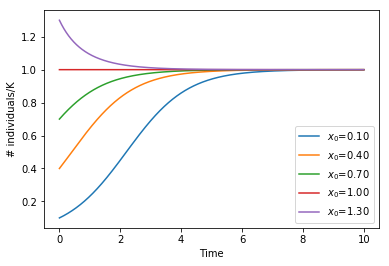

In [34]:
np.random.seed(1204565)
for m in np.arange(0.1,1.5,0.3):
  ts, lst_x, xi = log_growth_simulate(m, maxT=10)
  plt.plot(ts,lst_x, label='$x_0$='+"{:.2f}".format(m))
  #plt.plot(ts,lst_x+xi/np.sqrt(10), label='$x_0$='+"{:.2f}".format(m))
plt.xlabel('Time')
plt.ylabel('# individuals/K')
plt.legend()
plt.savefig('LOGG.png',bbox_inches='tight')
plt.show()

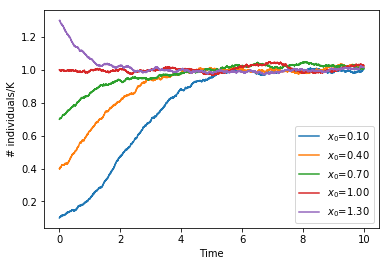

In [35]:
np.random.seed(1204565)
for m in np.arange(0.1,1.5,0.3):
  ts, lst_x, xi = log_growth_simulate(m, maxT=10)
  #plt.plot(ts,lst_x, label='$x_0$='+"{:.2f}".format(m))
  plt.plot(ts,lst_x+xi/np.sqrt(10), label='$x_0$='+"{:.2f}".format(m))
plt.xlabel('Time')
plt.ylabel('# individuals/K')
plt.legend()
plt.savefig('LOGG_SDE.png',bbox_inches='tight')
plt.show()

# TASK 5 - ADDENDUM

In [0]:
@jit
def log_growth_pois(b,K,m,nIters,nSamples):
  A = np.zeros((nSamples,nIters))
  ts = np.zeros((nSamples, nIters))
  #A[:,0] = np.random.choice(2*K, size=nSamples, replace=True)
  A[:,0]=1
  for n in range(nSamples):
    for t in range(nIters-1):
      At = A[n,t]
      wp = b*At
      wm = b*At*(At-1)/(K)
      w = wp + wm
      ts[n,t+1] = ts[n,t]+ np.random.exponential(w)
      if(np.random.rand()<wp/w):
        A[n,t+1]=At+1
      else:
        A[n,t+1]=At-1
  return ts, A

In [0]:
def log_growth_ppois(A, b=1, K=10, m=0.1):
  lnP_A = A*np.log(K)-np.log(sc.special.factorial(A))
  P_0=1/(np.exp(K)-1)  
  return np.exp(lnP_A+np.log(P_0))

In [0]:
ts_p, A_p = log_growth_pois(1, K, 0.1, 10000, 10000)

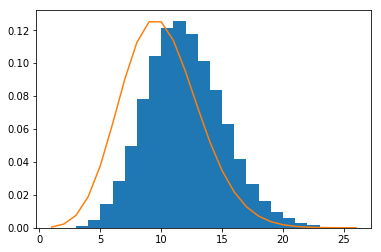

In [39]:
subAp = np.ravel(A_p[:,-5:-1] )
temp = np.arange(1,np.max(subAp)+1)
plt.hist(subAp, density=True, bins=temp)
plt.plot(temp, log_growth_ppois(temp, K=K))
plt.show()